In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.experimental import enable_halving_search_cv # explicitly require this experimental feature
from sklearn.model_selection import KFold, HalvingGridSearchCV, train_test_split, ShuffleSplit
from sklearn.svm import LinearSVC, SVC

# Reading Features

In [12]:
# Read EEG Features
features = pd.read_csv('all_features.csv', index_col=0)
features = features.dropna(subset=['targets'])
scores_max, scores_min = max(features['targets']), min(features['targets'])
N_CLASSES = 2
for subject_session in features.index:
    score = features.loc[subject_session]['targets']
    score = int((score-1e-6 - scores_min) / (scores_max - scores_min) * N_CLASSES)  # discretise
    features.loc[subject_session, 'targets'] = score
features.loc[:, 'targets'] = features['targets'].astype(int)

# Normalize each feature column
for column in features.columns[:-1]:
    features.loc[:, column] = (features[column] - features[column].min()) / (features[column].max() - features[column].min())

In [13]:
# Remove columns completely filled with NaNs
features = features.dropna(axis=1, how='all')

### Keep only some features?

From file? 

In [14]:
#selected_features = np.loadtxt('results/optimal_pli_only.txt', dtype=str)
selected_features = np.concatenate((np.loadtxt('results/optimal_pli_only.txt', dtype=str), np.loadtxt('results/optimal_64.txt', dtype=str)))
selected_features

array(['lowalpha_T3-P3', 'lowalpha_T4-P3', 'lowalpha_T5-F3',
       'lowalpha_T5-T4', 'lowalpha_T6-Fp1', 'delta_F8-F4', 'delta_O1-F4',
       'delta_P4-F4', 'delta_T3-F7', 'delta_T4-Fp1', 'delta_T6-T3',
       'highalpha_Fp1-C4', 'highalpha_Fp1-F7', 'highalpha_T4-T3',
       'highalpha_T5-Fp2', 'highalpha_T6-T3', 'beta_O2-F4', 'beta_O2-Fp1',
       'beta_T5-C3', 'theta_F3-C3', 'theta_F7-F3', 'theta_F8-F3',
       'theta_P4-F8', 'theta_T3-F3', 'theta_T6-F7',
       'C3_theta_relative_power', 'C4_theta_relative_power',
       'C4_highalpha_spectral_diff', 'C4_beta_spectral_flatness',
       'C4_lowgamma_relative_power', 'C4_lowgamma_spectral_flatness',
       'Cz_delta_relative_power', 'Cz_theta_spectral_entropy',
       'Cz_theta_spectral_flatness', 'Cz_lowalpha_spectral_diff',
       'Cz_highalpha_spectral_flatness', 'Cz_highalpha_spectral_diff',
       'Cz_lowgamma_spectral_entropy', 'Cz_lowgamma_spectral_flatness',
       'F3_theta_relative_power', 'F3_theta_spectral_flatness',
     

Select immediately? (e.g. to make feature selection on this subset)

In [15]:
features = features[np.append(selected_features, ['targets', ])]  # keep only the selected features and the targets
features.dropna(axis=0, inplace=True)  # Discard subjects with NaNs

Just some groups?

In [16]:
#targets = features.loc[:, 'targets']

# Only Spectral
#features = features.iloc[:, :600]

# Only Hjorth
#features = features.iloc[:, 600:666]

# Only PLI
#features = features.iloc[:, 666:-1]


###########################
#features.loc[:,'targets'] = targets  # restore targets
#features = features.dropna()  # remove NaNs

Show

In [17]:
features.head()

,lowalpha_T3-P3,lowalpha_T4-P3,lowalpha_T5-F3,lowalpha_T5-T4,lowalpha_T6-Fp1,delta_F8-F4,delta_O1-F4,delta_P4-F4,delta_T3-F7,delta_T4-Fp1,...,T3_theta_spectral_entropy,T4_theta_relative_power,T4_highalpha_spectral_entropy,T4_lowgamma_spectral_entropy,T4_lowgamma_spectral_flatness,T5_theta_spectral_entropy,T6_theta_relative_power,T6_lowgamma_spectral_entropy,T6_lowgamma_spectral_flatness,targets
300_2,0.238095,0.234694,0.175824,0.349754,2.087912e-01,0.298701,0.200000,0.183673,0.238095,0.376623,...,0.955690,0.613918,0.940277,0.853937,0.861653,0.962462,0.598220,0.484590,0.485363,1.0
042_1,0.148148,0.214286,0.269231,0.275862,3.132770e-08,0.318182,0.288889,0.142857,0.333333,0.227273,...,0.980346,0.453169,0.938398,0.764676,0.776280,0.943945,0.745716,0.549604,0.548771,1.0
261_2,0.111111,0.321429,0.230769,0.310345,2.692308e-01,0.227273,0.200000,0.142857,0.288889,0.363636,...,0.833681,0.506474,0.947940,0.764810,0.778628,0.000000,0.384719,0.382847,0.389348,0.0
327_1,0.415597,0.357143,0.342160,0.533819,3.766269e-01,0.822902,0.412991,0.270878,0.265811,0.351835,...,0.949164,0.346965,0.942630,0.734450,0.748667,0.913155,0.359049,0.542795,0.547940,0.0
200_2,0.425559,0.186665,0.070386,0.373449,2.605144e-01,0.423642,0.224300,0.420478,0.365187,0.350760,...,0.967288,0.655194,0.919274,0.629669,0.648594,0.821896,0.400464,0.348748,0.350532,0.0


# Model

In [18]:
params = {'class_weight': None,
          'criterion': 'gini',
          'max_depth': 5,
          'max_features': 'sqrt',
          'max_samples': None,
          'min_samples_leaf': 0.51,
          'min_samples_split': 5,
          'n_estimators': 500,
          'random_state': 0}
#model = RandomForestClassifier(**params)
model = RandomForestClassifier(500, max_depth=5, random_state=0) #, oob_score=True, warm_start=True)
#model = GradientBoostingClassifier(loss='exponential', n_estimators=100, criterion='friedman_mse', max_depth=3, learning_rate=0.1, random_state=0)
#model = SVC(kernel='rbf', C=4, class_weight='balanced', random_state=0)

# Run Purpose

Cross-Validation

In [19]:
CV = True
# 10-fold cross-validation
#cv = StratifiedShuffleSplit(n_splits=10, random_state=0)
#cv = StratifiedKFold(n_splits=10)  # sem shuffle
#cv = ShuffleSplit(n_splits=10, random_state=0)  # sem estratificação
#cv = KFold(n_splits=5)  # sem shuffle nem estratificação
# Leave-4-out cross-validation
#cv = StratifiedShuffleSplit(n_splits=179-4, random_state=0)
#cv = ShuffleSplit(n_splits=179-4, random_state=0)  # sem estratificação
#cv = KFold(n_splits=176-4)#len(features)-4)  # sem shuffle nem estratificação
cv = KFold(n_splits=len(features) // 4)  # sem shuffle nem estratificação
# My cross-validation
#cv = StratifiedLeavePOut(C=2, P=4, with_repetition=False)

In [20]:
# Sort subjects?
features = features.sort_index()
# Remove subjects without session pair?
features = features.drop(labels=['005_2', '102_2', '109_1', '195_2', '303_2'])
features.dropna(axis=0, inplace=True)  # Discard subjects with NaNs
features.head()

,lowalpha_T3-P3,lowalpha_T4-P3,lowalpha_T5-F3,lowalpha_T5-T4,lowalpha_T6-Fp1,delta_F8-F4,delta_O1-F4,delta_P4-F4,delta_T3-F7,delta_T4-Fp1,...,T3_theta_spectral_entropy,T4_theta_relative_power,T4_highalpha_spectral_entropy,T4_lowgamma_spectral_entropy,T4_lowgamma_spectral_flatness,T5_theta_spectral_entropy,T6_theta_relative_power,T6_lowgamma_spectral_entropy,T6_lowgamma_spectral_flatness,targets
003_1,0.555556,0.657143,0.584615,0.668966,0.446154,0.345455,0.306667,0.257143,0.573333,0.618182,...,0.917590,0.520918,0.911382,0.750272,0.761138,0.943000,0.596674,0.230187,0.230450,0.0
003_2,0.269841,0.234694,0.208791,0.261084,0.175824,0.181818,0.276190,0.142857,0.238095,0.259740,...,0.847459,0.431068,0.953421,0.661108,0.677053,0.972406,0.754676,0.720904,0.718389,0.0
004_1,0.155556,0.357143,0.123077,0.420690,0.676923,0.181818,0.306667,0.314286,0.253333,0.454545,...,0.969509,0.443410,0.897787,0.717253,0.735612,0.937004,0.675263,0.490773,0.487508,0.0
004_2,0.703704,0.500000,0.461538,0.310345,0.384615,0.363636,0.733333,0.238095,0.822222,0.545455,...,0.959975,0.381429,0.939636,0.714462,0.731291,0.972169,0.587301,0.436048,0.441635,0.0
008_1,0.333333,0.285714,0.461538,0.793103,0.461538,0.727273,0.644444,0.904762,0.288889,0.545455,...,0.942268,0.412536,0.935425,0.734992,0.751389,0.952731,0.540481,0.668551,0.662824,0.0


Selection

In [21]:
SELECTION = True
selector = RFECV
min_features_to_select = 10
max_features_to_select = 24
n_features_to_select = 24

Hyperparameters Tuning

In [22]:
HYPERPARAMETERS_TUNING = False
tunner = HalvingGridSearchCV
hyperparameters = (
    {'n_estimators': [100, 500, 1000],
     'criterion': ['gini', 'entropy', 'log_loss'],
     'max_depth': [5, 10, 20, None],
     'min_samples_split': [5, 10, 0.51],
     'min_samples_leaf': [1, 2, 0.51],
     'max_features': ['sqrt', 'log2'],
     'class_weight': [None, 'balanced', 'balanced_subsample'],
     'max_samples': [None, 0.5, 0.75, 0.9],
     }
)  # n_candidates: 7776

Sequential Selection

In [23]:
SEQUENTIAL_SELECTION = False
additional_features = None  # pli_features

# Evaluation

Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Optimal number of features: 74


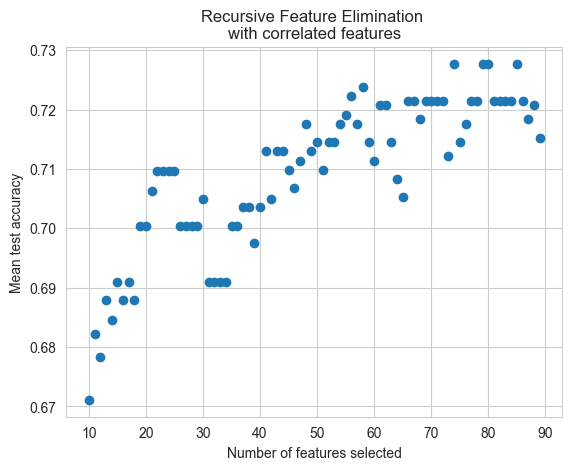

In [24]:
if SELECTION and CV and not HYPERPARAMETERS_TUNING:
    selector_cv = selector(estimator=model, step=1, cv=cv,
                            scoring='f1_weighted', min_features_to_select=min_features_to_select,
                            verbose=2, n_jobs=-1)

    selector_cv.fit(features.iloc[:, :-1], features['targets'])
    print(f"Optimal number of features: {selector_cv.n_features_}")

    # Plot number of features VS. cross-validation scores
    n_scores = len(selector_cv.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.scatter(
        range(min_features_to_select, n_scores + min_features_to_select),
        selector_cv.cv_results_["mean_test_score"],
        #yerr=selector_cv.cv_results_["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    plt.show()

    # Get optimal features
    selected_features = selector_cv.get_feature_names_out()

In [25]:
if SELECTION and not CV and not HYPERPARAMETERS_TUNING:
    #selector = RFE(estimator=model, n_features_to_select=100, step=1, verbose=2)
    #selector = selector(estimator=model, max_features=max_features_to_select)
    selector = selector(LinearSVC(dual=True, penalty="l2", loss='hinge'), max_features=max_features_to_select)
    selector.fit(features.iloc[:, :-1], features['targets'])
    selected_features = selector.get_feature_names_out()

In [26]:
selected_features

array(['lowalpha_T4-P3', 'lowalpha_T5-T4', 'lowalpha_T6-Fp1',
       'delta_F8-F4', 'delta_O1-F4', 'delta_P4-F4', 'delta_T3-F7',
       'delta_T4-Fp1', 'highalpha_Fp1-C4', 'highalpha_T4-T3',
       'highalpha_T5-Fp2', 'highalpha_T6-T3', 'beta_O2-F4', 'beta_O2-Fp1',
       'beta_T5-C3', 'theta_F3-C3', 'theta_F7-F3', 'theta_P4-F8',
       'theta_T3-F3', 'theta_T6-F7', 'C3_theta_relative_power',
       'C4_theta_relative_power', 'C4_highalpha_spectral_diff',
       'C4_beta_spectral_flatness', 'C4_lowgamma_relative_power',
       'C4_lowgamma_spectral_flatness', 'Cz_delta_relative_power',
       'Cz_theta_spectral_entropy', 'Cz_theta_spectral_flatness',
       'Cz_lowalpha_spectral_diff', 'Cz_highalpha_spectral_flatness',
       'Cz_highalpha_spectral_diff', 'Cz_lowgamma_spectral_entropy',
       'Cz_lowgamma_spectral_flatness', 'F3_theta_spectral_flatness',
       'F3_beta_spectral_entropy', 'F3_beta_spectral_diff',
       'F4_lowalpha_relative_power', 'F4_beta_spectral_flatness',
      

In [27]:
features = features[np.append(selected_features, ['targets', ])]  # keep only the selected features and the targets
features.dropna(axis=0, inplace=True)  # Discard subjects with NaNs

In [28]:
if CV and not SELECTION and not HYPERPARAMETERS_TUNING:
    from sklearn.model_selection import cross_val_score
    #print("Cross-Validation with StratifiedLeavePOut")
    #print("Number of splits:", cv.get_n_splits(features['targets']))
    #print("Size of test sets", cv.p * cv.c * 2)
    scores = cross_val_score(model, features[selected_features], features['targets'],
                              cv=cv, scoring='f1_weighted', verbose=2, n_jobs=-1)
    print("Cross-Validation mean score:", scores.mean())
    print("Cross-Validation std score:", scores.std())
    print("Cross-Validation max score:", scores.max())
    print("Cross-Validation min score:", scores.min())

In [29]:
if not CV and not SELECTION and not HYPERPARAMETERS_TUNING and not SEQUENTIAL_SELECTION:
    # Split subjects into train and test (using sklearn)
    train_size = 0.98
    n_train = int(len(features) * train_size)
    n_test = len(features) - n_train
    train_dataset, test_dataset = train_test_split(features, train_size=train_size,
                                                   shuffle=True,
                                                   #stratify=features['targets'],
                                                   random_state=1)
    train_features = train_dataset[selected_features]
    train_targets = train_dataset['targets']
    test_features = test_dataset[selected_features]
    test_targets = test_dataset['targets']
    print("Train features shape:", train_features.shape)
    print("Test features shape:", test_features.shape)

    # Train
    model = model.fit(train_features, train_targets)

    #test_features = train_features  # FIXME: remove this line
    #test_targets = train_targets  # FIXME: remove this line

    # Test
    predictions = model.predict(test_features)
    # Adjust predictions to the number of classes
    #predictions_min, predictions_max = 0, 1
    #for i in range(len(predictions)):
    #    predictions[i] = int((predictions[i]-1e-6 - predictions_min) / (predictions_max - predictions_min) * N_CLASSES)  # discretise

    # 7.1) Accuracy
    accuracy = accuracy_score(test_targets, predictions)

    # 7.2) F1-Score
    f1 = f1_score(test_targets, predictions, average='weighted')

    print(f'Accuracy: {accuracy}')
    print(f'F1-Score: {f1}')
    print('-----\n')

    # 8. Plot Confusion Matrix
    from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt

    cm = confusion_matrix(test_targets, predictions)
    df_cm = pd.DataFrame(cm, range(N_CLASSES), range(N_CLASSES))
    plt.figure(figsize=(10, 7))
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})  # font size
    plt.show()

In [30]:
if HYPERPARAMETERS_TUNING and CV and not SELECTION and not SEQUENTIAL_SELECTION:
    print("Hyperparameter tuning")
    #_tunner = tunner(model, hyperparameters, resource='n_samples', min_resources=int(179*0.5),
    #                 cv=cv, scoring='f1_weighted', error_score=0, random_state=0,
    #                 verbose=2, n_jobs=-1)

    _tunner = tunner(model, hyperparameters,
                     cv=cv, scoring='f1_weighted', error_score=0, random_state=0,
                     verbose=2, n_jobs=-1)

    _tunner.fit(features[selected_features], features['targets'])
    print("Finished hyperparameter tuning")
    print("Best parameters:", _tunner.best_params_)
    print("Best score:", _tunner.best_score_)
    print("All results:")
    all_results = pd.DataFrame(_tunner.cv_results_)
    print(all_results)

In [31]:
if SEQUENTIAL_SELECTION and not SELECTION and not CV and not HYPERPARAMETERS_TUNING:

    def _train_test(model, experimental_features, train_size=0.85):
        train_dataset, test_dataset = train_test_split(features, train_size=train_size, shuffle=True, stratify=features['targets'], random_state=0)
        train_features, train_targets = train_dataset[experimental_features], train_dataset['targets']
        test_features, test_targets = test_dataset[experimental_features], test_dataset['targets']
        model.fit(train_features, train_targets)
        predictions = model.predict(test_features)
        f1 = f1_score(test_targets, predictions, average='weighted')
        return f1

    # Baseline test
    f1_baseline = _train_test(RandomForestClassifier(**params), selected_features)

    # Iterate through 'additional_features' and add the one that improves the most the model
    print("Sequential feature selection")
    results = {'baseline': f1_baseline}
    for feature in additional_features.columns:
        experimental_set_features = np.append(selected_features, feature)
        f1 = _train_test(RandomForestClassifier(**params), experimental_set_features, train_size=0.98)
        print(f"With '{feature}'\nF1-score = {f1}\n")
        results[feature] = f1